In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

In [4]:
(train_X_orig, train_y_orig), (test_X_orig, test_y_orig) = mnist.load_data()

print('X_train: ' + str(train_X_orig.shape))
print('Y_train: ' + str(train_y_orig.shape))
print('X_test:  '  + str(test_X_orig.shape))
print('Y_test:  '  + str(test_y_orig.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [5]:
# normalized the data
train_X_flatten = train_X_orig.reshape(train_X_orig.shape[0], -1).T
train_X = train_X_flatten / 256

# one hot encoder
train_y = np.zeros((10, train_y_orig.shape[0]))
for count, y in enumerate(train_y_orig):
    train_y[y][count] = 1

train_X.shape, train_y.shape

((784, 60000), (10, 60000))

((60000, 10), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

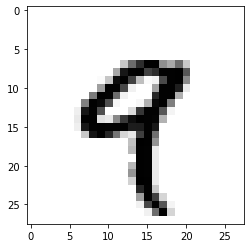

In [6]:
index = 4
plt.imshow(train_X_orig[4], cmap=plt.cm.gray_r)

train_y.T.shape, train_y.T[index]

In [7]:
def initialize_parameters(layer_dims): 
    """
    Using He initialization 

    Arguments:
    layers_dimension -  a python list of number of neruon in each layer
    Returns: 
    parameters - a python dictionary of numpy matrices and arrays of parameters of the netwrook, 
    """ 

    parameters = {}
    for l in range(1, len(layer_dims)): 
        parameters['W' + str(l)] = np.random.rand(layer_dims[l], layer_dims[l-1]) * np.sqrt(2/layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

In [8]:
dims = [10, 5, 5, 2]

parameters = initialize_parameters(dims)

print(parameters['W1'].shape)
print(parameters['W2'].shape)
print(parameters['W3'].shape)
print(len(parameters))

(5, 10)
(5, 5)
(2, 5)
6


In [9]:
def linear_forward(A_prev, W, b): 
    """ 
    Z = W dot A_prev + b
    """ 

    Z = np.dot(W, A_prev) + b
    cache = (A_prev, W, b)

    return Z, cache

In [10]:
def relu_activation(Z): 
    return np.maximum(0, Z)

In [11]:
def softmax_activation(Z):
    exp = np.exp(Z)
    return exp / exp.sum(axis=0)

In [12]:
def forward_propagation(X, parameters): 
    """
    (LINEAR -> RELU) * (L-1) -> LINEAR -> SOFTMAX

    Arguments: 
    x - nerual network input of shape (number of input neurons, number of examples)

    Returns: 
    AL - nerual network output of shape (number of output neurons, number of examples)
    caches - a python list of saved data for efficient backpagation
    """ 

    L = len(parameters) // 2
    caches = [] 
    A = X 
    for l in range(1, L): 
        A_prev = A
        Z, linear_cache = linear_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)])
        A = relu_activation(Z)
        cache = (linear_cache, Z)
        caches.append(cache)

    ZL, linear_cache = linear_forward(A, parameters['W' + str(L)], parameters['b' + str(L)])
    AL = softmax_activation(ZL)
    cache = (linear_cache, ZL)
    caches.append(cache)

    return AL, caches

In [13]:
def compute_cost(AL, Y): 
    """ calculate cross-entropy """ 
    loss = - np.sum(Y * np.log(AL), axis=0)
    cost = np.mean(loss)
    cost = np.squeeze(cost)
    return cost

In [14]:
def relu_activation_backward(dA, Z): 
    """ dZ = dA * relu'(Z) """ 
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

In [15]:
def linear_backward(dZ, cache):
    """
    dW = 1/m dZ[l]A[l-1].T
    db = 1/m sum(dZ)
    dA_prev = W.TdZ 
    """ 

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [16]:
def backward_propagation(AL, Y, caches): 
    """
    Arguments:
    AL - model output of shape (number of output neurons, number of examples)
    """

    grads = {}
    L = len(caches) 

    # the softmax layer
    dZL = AL - Y
    linear_cache, Z = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_backward(dZL, linear_cache)

    # relu layers
    for l in reversed(range(1, L)):
        linear_cache, Z = caches[l-1]
        dZ = relu_activation_backward(grads["dA" + str(l)], Z)
        grads["dA" + str(l-1)], grads["dW" + str(l)], grads["db" + str(l)] = linear_backward(dZ, linear_cache)

    return grads

In [17]:
def update_parameters(parameters, grads, learning_rate): 
    L = len(parameters) // 2
    
    for l in range(1, L+1): 
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]
    
    return parameters

In [18]:
def L_layer_model(X, Y, layers_dimensions, num_iterations, learning_rate=0.1, print_cost=False): 

    costs = []

    # initialize model
    parameters = initialize_parameters(layers_dimensions)

    for i in range(0, num_iterations):
        # forward propagation
        AL, caches = forward_propagation(X, parameters)

        # compute cost
        cost = compute_cost(AL, Y)

        # backward propatation
        grads = backward_propagation(AL, Y, caches)

        # updata parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # print and save cost value
        if print_cost and i % 100 == 0: 
            print ("Cost after iteration %i: %f" %(i, cost))
        costs.append(cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 3.859954
Cost after iteration 100: 1.583968
Cost after iteration 200: 0.913956
Cost after iteration 300: 0.602669
Cost after iteration 400: 0.452241
Cost after iteration 500: 0.365306
Cost after iteration 600: 0.329264
Cost after iteration 700: 0.304428
Cost after iteration 800: 0.284839
Cost after iteration 900: 0.268781
Cost after iteration 1000: 0.255225
Cost after iteration 1100: 0.243665
Cost after iteration 1200: 0.233654
Cost after iteration 1300: 0.224874
Cost after iteration 1400: 0.217079
Cost after iteration 1500: 0.210170
Cost after iteration 1600: 0.204018
Cost after iteration 1700: 0.198442
Cost after iteration 1800: 0.193291
Cost after iteration 1900: 0.188453


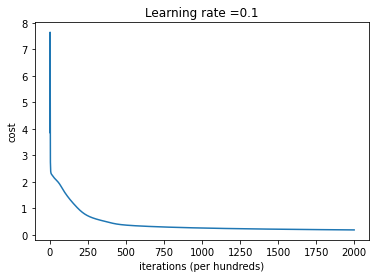

In [19]:
np.random.seed(1)

layers_dimensions = [784, 16, 16, 10]

parameters = L_layer_model(train_X, train_y, layers_dimensions, num_iterations=2000, learning_rate=0.1, print_cost=True)

In [20]:
def predict(X, parameters): 
    AL, caches = forward_propagation(X, parameters)
    return np.argmax(AL, axis=0)

In [21]:
# normalize
test_X_flatten = test_X_orig.reshape(test_X_orig.shape[0], -1).T
test_X = test_X_flatten / 256

y_hat = predict(test_X, parameters)

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y_orig, y_hat)

0.9426